## Week 4 NLP
### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("wordnet")
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/

## Import Data

In [2]:
df_train=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
print(df_train.shape)
df_train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Perform EDA

0    4342
1    3271
Name: target, dtype: int64


<Axes: ylabel='target'>

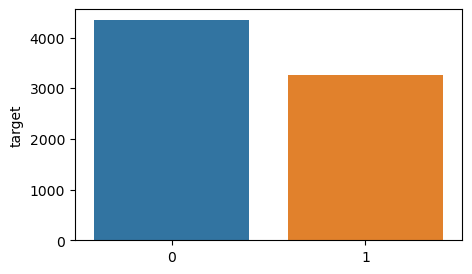

In [3]:
x = df_train["target"].value_counts()
print(x)
plt.figure(figsize=(5,3))
sns.barplot(x = x.index, y = x)

In [4]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Data Transformation and pre-processing

In [5]:
df_train["text"][3]

'13,000 people receive #wildfires evacuation orders in California '

In [6]:
text = '13,000 people receive #wildfires evacuation orders in California '

# switch to lowercase, remove punctuations & characters and then strip
def preprocess(text):
    text = text.lower() # change text
    text = text.strip()  # toss leading/trailing blanks 
    text = re.compile('<.*?>').sub('', text) # toss html tags
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(" ", text)  # remove punctuation
    text = re.sub('\s+', ' ', text)  # toss extra tabs
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text) 
    return text

text=preprocess(text)
print(text)

 people receive wildfires evacuation orders in california


In [7]:
# remove stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words("english")]
    return " ".join(a)

text = stopword(text)
print(text)

people receive wildfires evacuation orders california


In [8]:
# stemming
snow = SnowballStemmer("english")
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string)]
    return " ".join(a)
text = stemming(text)
print(text)

peopl receiv wildfir evacu order california


In [9]:
# lemmatization
wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
# tokenization
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

text = lemmatizer(text)
print(text)

peopl receiv wildfir evacu order california


In [11]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train["clean_text"] = df_train["text"].apply(lambda x: finalpreprocess(x))
df_train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get sent photo ruby alaska smoke wildfires pou...


## Train Model

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["target"], test_size=0.2, shuffle=True)

In [13]:
# TF-IDF
# switch x_train to a vector since the model can only run on numbers and not words - fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
# only transform x_test
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

## Logistic Regression

In [14]:
lr = LogisticRegression(solver="liblinear", C=10, penalty="l2")
lr.fit(X_train_vectors_tfidf, y_train)

# predicting y value for test dataset
y_pred = lr.predict(X_val_vectors_tfidf)
y_prob = lr.predict_proba(X_val_vectors_tfidf)[:,1]
 
print(classification_report(y_val,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print("\nAUC:", roc_auc)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       889
           1       0.73      0.76      0.75       634

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Confusion Matrix:
 [[714 175]
 [152 482]]

AUC: 0.8619998012866689


## Naive Bayes

In [15]:
nb = MultinomialNB()
nb.fit(X_train_vectors_tfidf, y_train)

# predicting y value for test dataset
y_pred = nb.predict(X_val_vectors_tfidf)
y_prob = nb.predict_proba(X_val_vectors_tfidf)[:,1]
 
print(classification_report(y_val,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print("\nAUC:", roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       889
           1       0.83      0.69      0.75       634

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Confusion Matrix:
 [[798  91]
 [197 437]]

AUC: 0.8557775901040761


## Test Model Fitness

In [16]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [17]:
# testing on new dataset with the best model
df_test["clean_text"] = df_test["text"].apply(lambda x: finalpreprocess(x))
X_test = df_test["clean_text"] 
# converting X_test to vector
X_vector = tfidf_vectorizer.transform(X_test)
# using the trained model on X_vector
y_pred = lr.predict(X_vector)
y_prob = lr.predict_proba(X_vector)[:,1]
df_test["predict_prob"] = y_prob
df_test["target"] = y_pred
print(df_test.head())

final = df_test[["id", "target"]].reset_index(drop=True)
final.to_csv("submission.csv", index=False)

   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires   
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan   

                                          clean_text  predict_prob  target  
0                          happen terrible car crash      0.883480       1  
1  heard earthquake different city stay safe ever...      0.768656       1  
2  forest fire spot pond geese flee across street...      0.918312       1  
3                  apocalypse light spokane wildfire      0.885199       1  
4                 typhoon soudelor kill china taiwan      0.994929       1  
